# Label Detection using Image Classification

## Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random

#Import Image Libraries - Pillow and OpenCV
import cv2
from PIL import Image

# Import TensorFlow and useful functions
import tensorflow
import math
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

In [2]:
tensorflow.__version__

'2.3.0'

## Load .json file and convert to Dataframe
The .json file was created using the SuperAnnotate labelling tool. The images were labelled with bounding boxes into 3 classes:
<br>
1) Heat Number
<br>
2) Dimension
<br>
3) Grade

In [3]:
# Load json file into data
with open('Images/classes.json') as f:
    data_class = json.load(f)
    
with open('Images/annotations.json') as f:
    data = json.load(f)

In [4]:
# Loop over dict in data to create lists
key_list = []
class_list = []
class_type = []
x1_list = []
x2_list = []
y1_list = []
y2_list = []

for k in data.keys():
    # Note: This assumes 3 labels per image, if more labels this code needs to be modified
    for x in range(0,3):
        try:
            if "classId" in data[k][x].keys():
                key_list.append(k)
                class_list.append(data[k][x]["classId"])
                x1_list.append(data[k][x]["points"]["x1"])
                x2_list.append(data[k][x]["points"]["x2"])
                y1_list.append(data[k][x]["points"]["y1"])
                y2_list.append(data[k][x]["points"]["y2"])
                for j in range(0,3):
                    try:
                        if data_class[j]['id'] == data[k][x]["classId"]:
                            class_type.append(data_class[j]['name'])
                        else:
                            continue
                    except IndexError:
                        pass
            else:
                continue
        except IndexError:
            pass

In [5]:
# Combine lists into dataframe
coord_df = pd.DataFrame([key_list, class_list, class_type, x1_list, x2_list, y1_list, y2_list]).T
coord_df.columns = ["filename", "class", "class_type", "x1", "x2", "y1", "y2"]
coord_df.head()

,filename,class,class_type,x1,x2,y1,y2
0,Image_0071.jpg,1,Heat Number,524,591.3,1416.1,1436.8
1,Image_0071.jpg,2,Dimension,523.2,691.6,1470.7,1534.7
2,Image_0071.jpg,3,Grade,485.4,528.6,1453.2,1468.7
3,Image_0062.jpg,1,Heat Number,726.3,781.7,1115.4,1135.4
4,Image_0062.jpg,2,Dimension,733,881.7,1068.7,1091.6


## Data Visualization
Distribution of classes

/home/dannylzj/miniconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


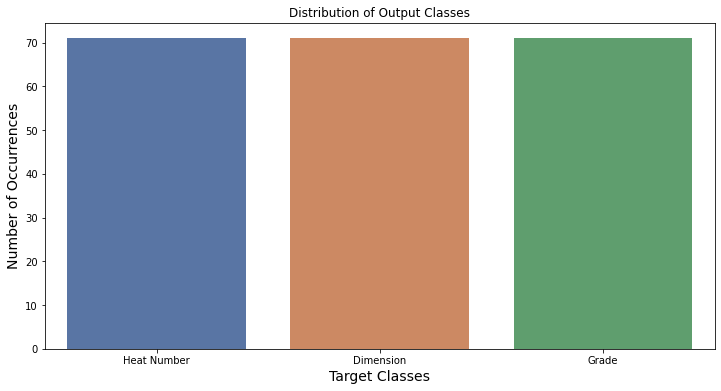

In [6]:
counts = coord_df['class'].value_counts()
class_list = ['Heat Number', 'Dimension', 'Grade']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i+1)

plt.figure(figsize=(12,6))
sns.barplot(counts.index, counts.values, alpha=1, palette='deep')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Target Classes', fontsize=14)
plt.show()

## Data Processing
### Batch cropping and resizing of images

In [7]:
# Batch crop and resize images
im_count = 0
class_folders = ['heat_number', 'dimension', 'grade']
for label in class_folders:
    if not os.path.exists('./cropped/' + label):
        os.makedirs('./cropped/' + label)
    if not os.path.exists('./resized/' + label):
        os.makedirs('./resized/' + label)

print('Batch crop and resizing in progress ..')
for x in coord_df.index:
    image = cv2.imread('Images/' + coord_df['filename'][x])
    x1, x2, y1, y2 = round(coord_df['x1'][x]), round(coord_df['x2'][x]), round(coord_df['y1'][x]), round(coord_df['y2'][x])
#     print('Processing ' + coord_df['filename'][x] + ' Class ' + str(coord_df['class'][x]) + ' ..')
    ROI = image[y1:y2,x1:x2]
    resized = cv2.resize(ROI, (224,224), interpolation = cv2.INTER_AREA)
    if (coord_df['class'][x] == 1):
        cv2.imwrite('cropped/heat_number/' + coord_df['filename'][x], ROI)
        cv2.imwrite('resized/heat_number/' + coord_df['filename'][x], resized)
    elif (coord_df['class'][x] == 2):
        cv2.imwrite('cropped/dimension/' + coord_df['filename'][x], ROI)
        cv2.imwrite('resized/dimension/' + coord_df['filename'][x], resized)
    else:
        cv2.imwrite('cropped/grade/' + coord_df['filename'][x], ROI)
        cv2.imwrite('resized/grade/' + coord_df['filename'][x], resized)
    im_count+=1
print("Total Images Processed: " + str(im_count))

Batch crop and resizing in progress ..
Total Images Processed: 213


### Visualizing Cropped and Resized Images

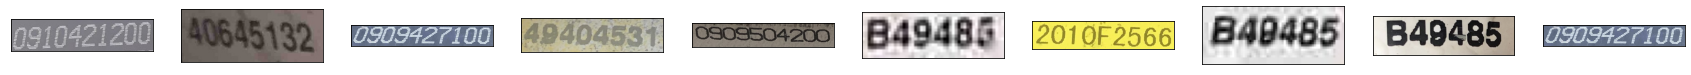

In [8]:
fig = plt.figure(figsize=(30, 16))
# display 10 images
heat_num_imgs = os.listdir("./cropped/heat_number")
# dim_imgs = os.listdir("./cropped/dimension")
# grade_imgs = os.listdir("./cropped/grade")
for idx, img in enumerate(np.random.choice(heat_num_imgs, 10)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./cropped/heat_number/" + img)
    plt.imshow(im)

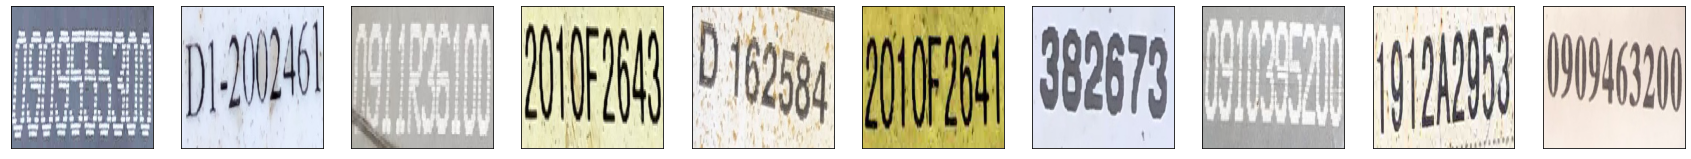

In [9]:
fig = plt.figure(figsize=(30, 16))
# display 10 images
heat_num_imgs = os.listdir("./resized/heat_number")
# dim_imgs = os.listdir("./resized/dimension")
# grade_imgs = os.listdir("./resized/grade")
for idx, img in enumerate(np.random.choice(heat_num_imgs, 10)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./resized/heat_number/" + img)
    plt.imshow(im)

### Train test split

In [10]:
test_ratio = 0.20

root_dir = './resized/'

for label in class_folders:
    if not os.path.exists('./train_dataset/' + label):
        os.makedirs('./train_dataset/' + label)
    if not os.path.exists('./test_dataset/' + label):
        os.makedirs('./test_dataset/' + label)
    
    src = root_dir + label
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                      [int(len(allFileNames)* (1 - test_ratio))])
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print("*****************************")
    print('Images in ' + root_dir + label)
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))
    print("*****************************")

    # Copy-pasting images
    for name in train_FileNames:
          shutil.copy(name, './train_dataset/' + label)
    for name in test_FileNames:
           shutil.copy(name, './test_dataset/' + label)
    print("Copying Done!")

*****************************
Images in ./resized/heat_number
Total images:  71
Training:  56
Testing:  15
*****************************
Copying Done!
*****************************
Images in ./resized/dimension
Total images:  71
Training:  56
Testing:  15
*****************************
Copying Done!
*****************************
Images in ./resized/grade
Total images:  71
Training:  56
Testing:  15
*****************************
Copying Done!


## Modeling

### Train-validation split and Image Augmentation Settings
Setting up Keras ImageDataGenerator to perform train-validation split and image augmentation in real-time during model training.

In [11]:
# Validation ImageDataGenerator with rescaling
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

# Training ImagaDataGenerator with Augmentation transformation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2,
                                   rotation_range=15,
                                   brightness_range= [0.5, 1.5],
                                   channel_shift_range=40,
#                                    shear_range=10,
#                                    zoom_range=0.1,
                                   fill_mode='nearest',
#                                    height_shift_range=0.2,
#                                    width_shift_range=0.2
                                  )

# Create a flow from the directory for validation data - seed=42
# Choose subset = 'validation'
valid_gen = valid_datagen.flow_from_directory(directory='train_dataset',
                                              subset='validation',
                                              shuffle=True,
                                              seed=42, # seed to ensure same validation split for both train_gen and valid_gen
                                              target_size=(224,224),
                                              batch_size=64,
#                                               save_to_dir='valid_gen', # for image visualization
                                              class_mode='categorical')

# Create a flow from the directory using same seed and 'training' subset.
train_gen = train_datagen.flow_from_directory(directory='train_dataset',
                                              subset='training',
                                              shuffle=True,
                                              seed=42, # seed to ensure same validation split for train_gen and valid_gen
                                              target_size=(224,224),
                                              batch_size=64,
#                                               save_to_dir='train_gen', # for image visualization
                                              class_mode='categorical')

Found 33 images belonging to 3 classes.
Found 135 images belonging to 3 classes.


### Define Model Checkpoint and Learning Rate Scheduler

In [12]:
# Define checkpoint to save best weights
filepath="weights.Xception.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [13]:
# Define learning rate scheduler
# Time-based learning rate
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

# Step decay learning rate - Drop learning rate by 0.5 for every 10 epochs
def step_decay(epoch):
    initial_lrate = 0.005
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor(epoch/epochs_drop))
    return lrate

# Using step decay
lrate = LearningRateScheduler(step_decay)

# Define callbacks list
callbacks_list = [checkpoint, lrate]

### Define Model Architecture

In [14]:
# Define number of classes and image size
num_classes = 3
image_size = 224

# Instantiate Xception base model with imagenet with global average pooling
xception = Xception(weights='imagenet',
            include_top=False,
            pooling='avg',
            input_shape=(image_size, image_size, 3))

# Create the model
my_model = models.Sequential()

# Add Xception base model - Re-train only fully connected layers to num_classes
my_model.add(xception)
my_model.add(layers.Dense(num_classes, activation='softmax'))
my_model.layers[0].trainable = False
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________


### Training and Validation

In [15]:
# Specify optimizer
rmsprop = RMSprop(learning_rate=0.0,
                  momentum=0.9)

# Compile model
my_model.compile(optimizer=rmsprop,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [16]:
# Number of epochs to train the model
n_epochs = 50

history = my_model.fit(train_gen, epochs=n_epochs, validation_data=valid_gen, callbacks=callbacks_list)

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 1.4510 - accuracy: 0.3333
Epoch 00001: val_accuracy improved from -inf to 0.57576, saving model to weights.Xception.best.hdf5
3/3 [==============================] - 15s 5s/step - loss: 1.4510 - accuracy: 0.3333 - val_loss: 1.9293 - val_accuracy: 0.5758
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 1.8242 - accuracy: 0.5259
Epoch 00002: val_accuracy did not improve from 0.57576
3/3 [==============================] - 13s 4s/step - loss: 1.8242 - accuracy: 0.5259 - val_loss: 1.6623 - val_accuracy: 0.5455
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 1.4350 - accuracy: 0.6593
Epoch 00003: val_accuracy did not improve from 0.57576
3/3 [==============================] - 13s 4s/step - loss: 1.4350 - accuracy: 0.6593 - val_loss: 1.8618 - val_accuracy: 0.5758
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 1.2058 - accuracy: 0.7407
Epoch 00004: val_accuracy did not improve

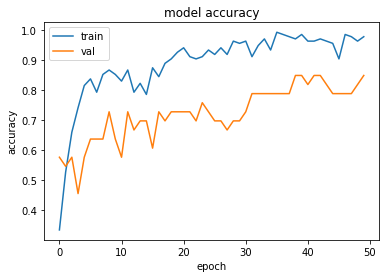

In [17]:
# Plot model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

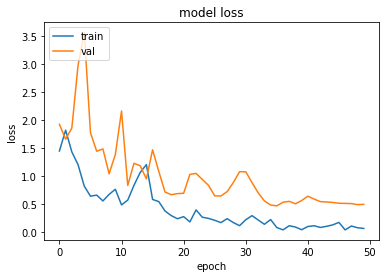

In [18]:
# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Evaluation

In [19]:
my_model.load_weights('weights.Xception.best.hdf5')

In [20]:
# Create a flow from the directory for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(directory='test_dataset',
                                            target_size=(224,224),
                                            batch_size=1,
                                            shuffle=False,
#                                             save_to_dir='test_gen',
                                            class_mode='categorical')

Found 45 images belonging to 3 classes.


In [21]:
# Evaluate model on test set
scores = my_model.evaluate(test_gen)

45/45 [==============================] - 6s 129ms/step - loss: 0.4512 - accuracy: 0.8889


In [22]:
# Predict probabilities
prediction = my_model.predict(test_gen)

In [23]:
# Predict class based on highest probability
y_classes = prediction.argmax(axis=-1)
print(y_classes)

[0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


In [24]:
# Output labels, Keras generator sorts the labels by alphabetical order
filename = []
actual = []
predicted = []
for file in test_gen.filenames:
    filename.append(file.split('/')[1])
    actual.append(file.split('/')[0])

labels = ['dimension', 'grade', 'heat_number']
for i in y_classes:
    predicted_label = sorted(labels)[i]
    predicted.append(predicted_label)

In [25]:
# Dataframe to compare predictions
df = pd.DataFrame([filename, actual, predicted]).T
df.columns = ['filename', 'actual label', 'predicted class']
df

,filename,actual label,predicted class
0,Image_0005.JPG,dimension,dimension
1,Image_0006.JPG,dimension,dimension
2,Image_0012.JPG,dimension,heat_number
3,Image_0014.JPG,dimension,dimension
4,Image_0018.JPG,dimension,dimension
5,Image_0019.JPG,dimension,heat_number
6,Image_0025.JPG,dimension,dimension
7,Image_0033.JPG,dimension,dimension
8,Image_0035.JPG,dimension,dimension
9,Image_0036.jpg,dimension,dimension
